Exploring the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import sys
import importlib
import functions.functions as aux_fun
importlib.reload(aux_fun)
from datetime import datetime as dti

from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None 

Reading data

In [2]:
# Read data

# Portifolio and profile datasets
portfolio = pd.read_csv('portfolio.csv')
profile = pd.read_csv('profile2.csv')

# User and offer data, already treated in Data Preparation 
user_offer_df = pd.read_csv('user_offer.csv').astype({'offer_id_rec':np.int8})

# Reading the hexideciamal to int dictonaries
map_portifolio = json.load(open('mapper_id/portifolio_ids.json'))
map_profile = json.load(open('mapper_id/profile_ids.json'))

Quick look at the data

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,6
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,7
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,9


In [4]:
profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years
0,NI,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03
2,NI,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,0.04
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21
4,NI,55.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,0.98


In [5]:
user_offer_df.head()

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3
4,4,1.0,0.0,1.09,1.0,NaN,0.0,4


#### Data preparation for analysis

##### 3. Merging datasets

Merging the user offer dataset with profile and portifolio dataset  

The extra information will be used to exploring the data.

In [6]:
# Just interesting columns from profile and portifolio
# Profile
profile2 = profile[['user_id', 'gender', 'age', 'income', 'rela_member_years']]

# Portifolio
portfolio2 = portfolio[['offer_id', 'reward', 'difficulty', 'offer_type']]
portfolio2.columns = ['offer_id', 'offer_reward', 'offer_difficulty', 'offer_type']

# Merging with user_offer_id

user_offer_df2 =  user_offer_df.merge(portfolio2, left_on='offer_id_rec', right_on='offer_id')
user_offer_df2 = user_offer_df2.merge(profile2, on='user_id')

user_offer_df2.head() 



,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_years
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,informational,F,75.0,100000.0,1.21
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3,3,5,5,bogo,F,75.0,100000.0,1.21
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3,0,10,10,bogo,F,75.0,100000.0,1.21
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,bogo,F,75.0,100000.0,1.21
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,informational,NI,55.0,64000.0,0.98


Informações contínuas, como renda e idade podem ser melhor analisadas a partir do seu agrupamento.  
O melhor agrupamento para uma única variável é nos quartis, separando os dados em 4 partes iguais.

In [7]:
user_offer_df2['age_quartile'] = pd.qcut(user_offer_df2['age'], q=4)
user_offer_df2['age_decile'] = pd.qcut(user_offer_df2['age'], q=10)
user_offer_df2['income_quartile'] = pd.qcut(user_offer_df2['income'], q=4)
# user_offer_df2['member_days_quartile'] = pd.qcut(user_offer_df2['rela_member_days'], q=4)
user_offer_df2['member_years_quartile'] = pd.qcut(user_offer_df2['rela_member_years'], q=4)

user_offer_df2.head()

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_years,age_quartile,age_decile,income_quartile,member_years_quartile
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,informational,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(0.98, 2.17]"
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3,3,5,5,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(0.98, 2.17]"
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3,0,10,10,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(0.98, 2.17]"
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(0.98, 2.17]"
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,informational,NI,55.0,64000.0,0.98,"(45.0, 55.0]","(54.0, 55.0]","(51000.0, 64000.0]","(0.57, 0.98]"


#### Modeling data

Cluster dos perfis

In [8]:
profile2 = profile2.set_index('user_id')

In [127]:
# Data

# Tranformar as categorias em número
profile2

# Discretizar os intervalos
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder

discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

numerics  = profile2[['age', 'income','rela_member_years']]

profile[['age_c','income_c', 'time_c']] = discretizer.fit_transform(numerics)

encoder_ = OrdinalEncoder()

gender = profile2[['gender']]

profile['gender_c'] = encoder_.fit_transform(gender)


In [74]:
profile['income_quar'] = pd.qcut(profile.income, q=4, labels=[0,1,2,3])

In [146]:
profile_ = profile[['user_id','age_c', 'income_c', 'time_c', 'gender_c']]

profile_['g'] = profile_[['age_c', 'income_c', 'time_c', 'gender_c']].apply(lambda x: list(x), axis=1)

profile_['g'] = profile_.g.map(str)


af = OrdinalEncoder()

aa = af.fit_transform(profile_[['g']])

aa


array([[ 52.],
       [ 74.],
       [ 48.],
       ...,
       [ 51.],
       [132.],
       [108.]])

In [85]:
profile3 = profile3.join(profile2[['gender']])

##### Preparing the data

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
user_offer_df2

model_df = pd.get_dummies(data=user_offer_df2, columns=['offer_id_rec', 'offer_type', 'gender', 'income_quartile', 'age_quartile'])

model_df.head()

,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,...,gender_NI,gender_O,"income_quartile_(29999.999, 51000.0]","income_quartile_(51000.0, 64000.0]","income_quartile_(64000.0, 76000.0]","income_quartile_(76000.0, 120000.0]","age_quartile_(17.999, 45.0]","age_quartile_(45.0, 55.0]","age_quartile_(55.0, 64.0]","age_quartile_(64.0, 101.0]"
0,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1.0,1.0,19.89,1.0,1.0,5.0,3,3,5,5,...,0,0,0,0,0,1,0,0,0,1
2,1.0,1.0,21.72,1.0,1.0,10.0,3,0,10,10,...,0,0,0,0,0,1,0,0,0,1
3,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,...,0,0,0,0,0,1,0,0,0,1
4,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,...,1,0,0,1,0,0,0,1,0,0


In [20]:
user_offer_df2

model_df = pd.get_dummies(data=user_offer_df2, columns=['offer_id_rec', 'offer_type', 'gender', 'income_quartile', 'age_quartile'])

model_df = model_df.loc[model_df.gender_NI==0]

y = model_df['tra_offer_infl']

X = model_df[['offer_id_rec_0', 'offer_id_rec_1', 'offer_id_rec_2', 'offer_id_rec_3',
       'offer_id_rec_4', 'offer_id_rec_5', 'offer_id_rec_6', 'offer_id_rec_7',
       'offer_id_rec_8', 'offer_id_rec_9', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'gender_F',
       'gender_M', 'gender_NI', 'gender_O',
       'income_quartile_(29999.999, 51000.0]',
       'income_quartile_(51000.0, 64000.0]',
       'income_quartile_(64000.0, 76000.0]',
       'income_quartile_(76000.0, 120000.0]', 'age_quartile_(17.999, 45.0]',
       'age_quartile_(45.0, 55.0]', 'age_quartile_(55.0, 64.0]',
       'age_quartile_(64.0, 101.0]']]


model = LinearRegression()

model.fit(X, y)

model.score(X, y)

def prever(n):
       x_ = X.iloc[:n]
       y_ = y.iloc[:n]
       model = LinearRegression()
       model.fit(X, y)
       return model.score(X, y)

rang =  np.arange(0,  len(model_df), 100)

res = []
for n in rang:
       res.append(prever(n))




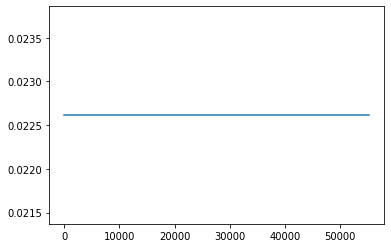

In [21]:
plt.plot(rang, res)

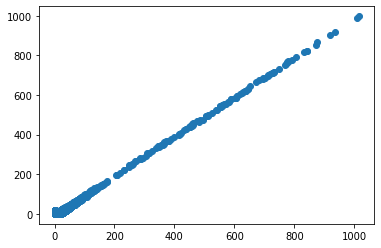

In [23]:
residuals = np.sqrt((model.predict(X) - y)**2 )

plt.scatter(y,residuals)